<a href="https://colab.research.google.com/github/AhamedSulaiman/Stock_market_DS/blob/main/STOCK_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

In [4]:
df = pd.read_csv("nifty_stock.csv")
df.head()

,date,symbol,series,prev_close,open_,high,low,last_,close_,vwap,volume,turnover,trades,deliverable_volume,deliverble_per,daily_return,price_range,date_fixed
0,27-11-2007,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.690000e+15,0,9859619.0,0.3612,1.1884,280.00,2007-11-27
1,28-11-2007,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.310000e+14,0,1453278.0,0.3172,-0.0717,116.00,2007-11-28
2,29-11-2007,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550000e+14,0,1069678.0,0.2088,-0.0109,73.75,2007-11-29
3,30-11-2007,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.280000e+14,0,1260913.0,0.2735,0.0422,68.00,2007-11-30
4,03-12-2007,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.880000e+14,0,816123.0,0.2741,0.0518,73.00,2007-12-03


In [5]:
df['date'] = pd.to_datetime(df['date'])

# Sort by time (VERY IMPORTANT)
df = df.sort_values(by='date').reset_index(drop=True)

/tmp/ipython-input-4026461988.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [6]:
df['prev_close_1'] = df.groupby('symbol')['close_'].shift(1)
df['prev_close_2'] = df.groupby('symbol')['close_'].shift(2)

In [7]:
df['ma_5'] = df.groupby('symbol')['close_'].rolling(5).mean().reset_index(0, drop=True)
df['ma_10'] = df.groupby('symbol')['close_'].rolling(10).mean().reset_index(0, drop=True)

In [8]:
df['volatility_5'] = df.groupby('symbol')['close_'].rolling(5).std().reset_index(level=0, drop=True)

<Axes: >

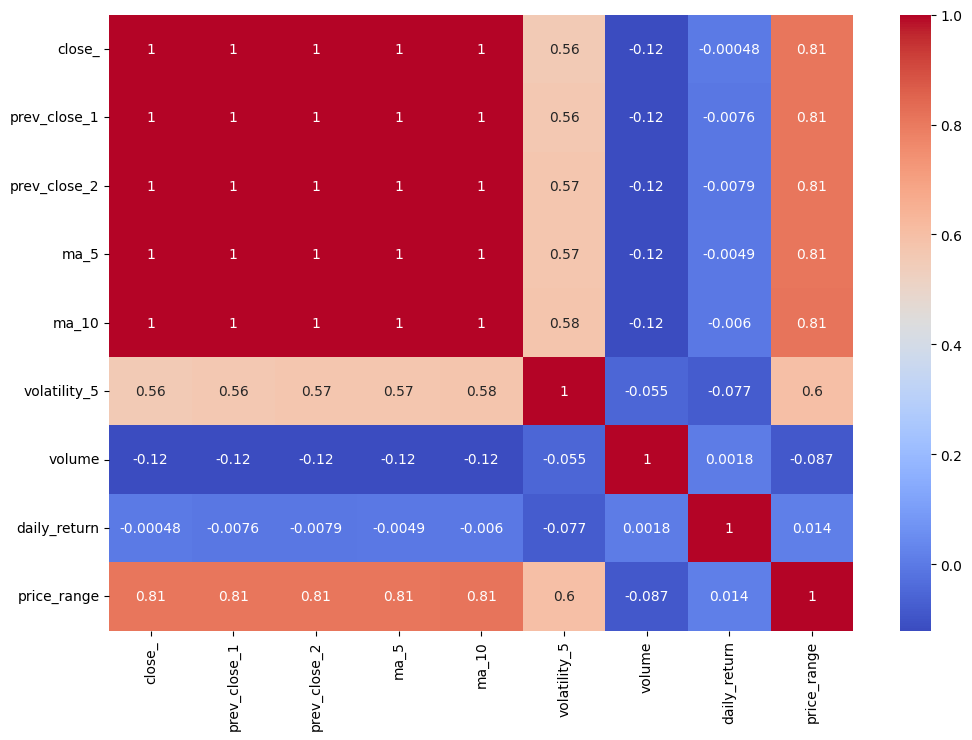

In [24]:
corr_features = [
    'close_','prev_close_1','prev_close_2',
    'ma_5','ma_10','volatility_5',
    'volume','daily_return','price_range'
]

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [9]:
features = [
    'prev_close_1',
    'prev_close_2',
    'ma_5',
    'ma_10',
    'volatility_5',
    'volume'
]

X = df[features]
y = df['close_']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

In [11]:
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=150, n_jobs=-1,
                      random_state=42)

In [12]:
y_pred = rf_model.predict(X_test)

In [13]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest Performance")
print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))

Random Forest Performance
MAE : 37.566
RMSE: 166.37


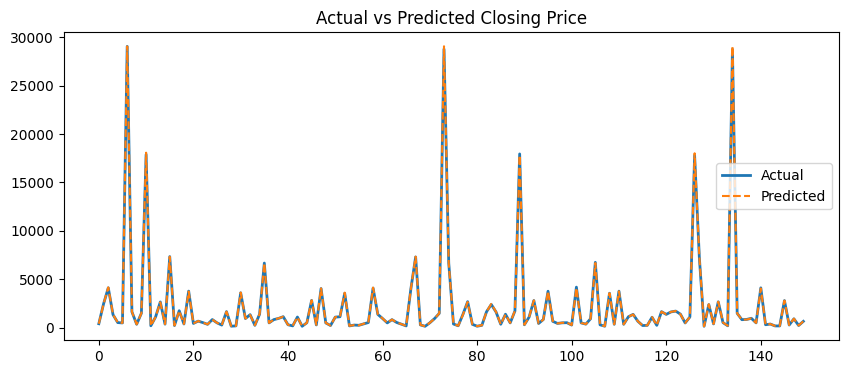

In [14]:
plt.figure(figsize=(10,4))
plt.plot(y_test.values[:150], label='Actual', linewidth=2)
plt.plot(y_pred[:150], label='Predicted', linestyle='--')
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

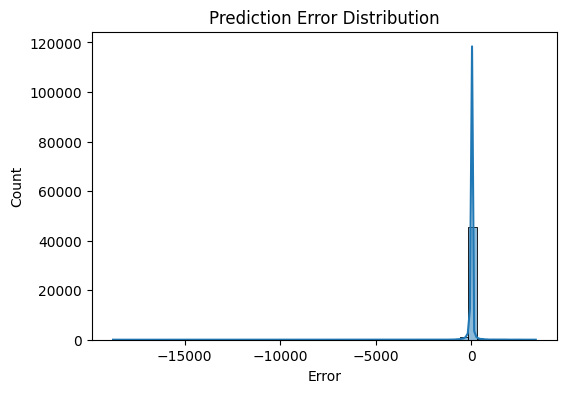

In [15]:
errors = y_test - y_pred

plt.figure(figsize=(6,4))
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.show()

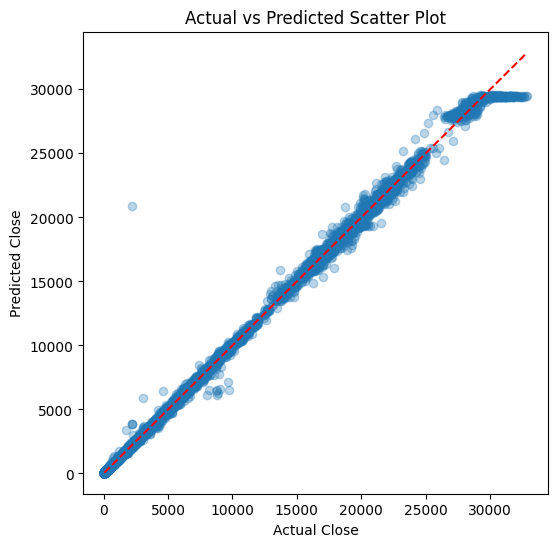

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("Actual vs Predicted Scatter Plot")
plt.show()

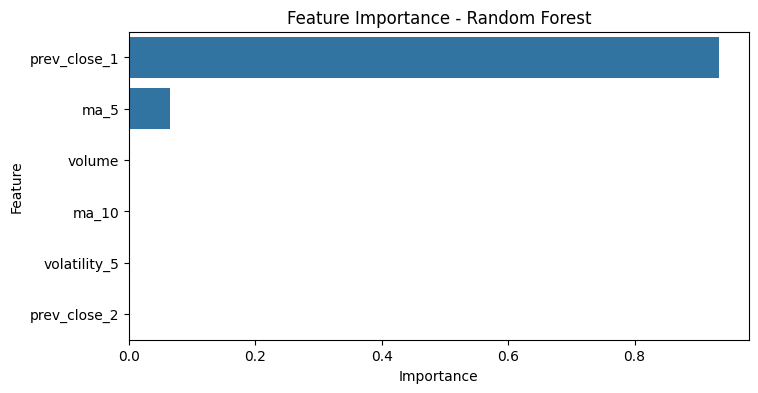

In [17]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance
)
plt.title("Feature Importance - Random Forest")
plt.show()

In [18]:
joblib.dump(rf_model, "random_forest_stock_model.pkl")
print("Model saved successfully")

Model saved successfully


In [19]:
results = X_test.copy()
results['actual_close'] = y_test.values
results['predicted_close'] = y_pred

results.to_csv("stock_price_predictions.csv", index=False)

print("Predictions saved successfully")

Predictions saved successfully


In [20]:
latest_row = df.iloc[-1]

next_input = pd.DataFrame([{
    'prev_close_1': latest_row['close_'],
    'prev_close_2': df.iloc[-2]['close_'],
    'ma_5': df['close_'].tail(5).mean(),
    'ma_10': df['close_'].tail(10).mean(),
    'volatility_5': df['close_'].tail(5).std(),
    'volume': latest_row['volume']
}])

next_day_price = rf_model.predict(next_input)[0]

print("📈 Predicted next-day closing price:", round(next_day_price, 2))


📈 Predicted next-day closing price: 189.16


In [21]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("RF RMSE:", round(rf_rmse, 2))
print("XGB RMSE:", round(xgb_rmse, 2))

RF RMSE: 166.37
XGB RMSE: 963.37
